In [55]:
from numpy import eye, linalg, arange, sqrt, diag, sin, pi, linspace, heaviside, sum as npsum, multiply, conjugate, real, array, zeros, copy, var, std, append, mean
import numpy.fft as fft
import matplotlib.pyplot as plt

In [44]:
# funcaozinha para inserir o range do eixo x, autovalores, autovetores e o numero de energias desejado na visualização; possivel inserir potencial para plotar junto
def plotEnPsi_finite_diff(
    x_values,
    en,
    psi,
    n,
    scale,
    ymin,
    ymax,
    xmin=0,
    xmax=800,
    potential=0,
    imgName="",
    save=True,
):
    # spot_size = 1
    plt.plot(x_values, potential, c="C1140")
    mu=en[-1]
    plt.hlines(
        mu,
        xmin=x_values[0],
        xmax=x_values[-1],
        colors="black",
        linestyles="--",
        label=r'$\mu$'
    )
    en = en[:-1]
    for j in range(n):
        plt.hlines(
            en[j],
            xmin=x_values[0],
            xmax=x_values[-1],
            colors="C" + str(j),
            linestyles="--",
        )
        plt.plot(x_values, en[j] + scale * psi[:, j], c="C" + str(j))
        y_min, y_max = (ymin, ymax)
        plt.ylim(y_min, y_max)
        x_min, x_max = (xmin, xmax)
        plt.xlim(x_min, x_max)
    plt.legend()
    plt.tight_layout()
    if save:
      plt.savefig(str(imgName) + ".png", dpi=120)
      plt.close()
    else:
      plt.show()


In [ ]:
# funcaozinha para visualizar as bandas (uma visão apenas 2D)
def plotEnKparallel_finite_diff(
    kpar_values,
    en,
    n,
    mass,
    ymin,
    ymax,
    xmin=0,
    xmax=800,
    imgName="",
    save=True,
):
    for j in range(n):
        plt.hlines(
            en[j],
            xmin=kpar_values[0],
            xmax=kpar_values[-1],
            colors="C" + str(j),
            linestyles="--",
        )
        plt.plot(kpar_values, en[j] + (1/(2*mass))* (kpar_values**2), c="C" + str(j))
        y_min, y_max = (ymin, ymax)
        plt.ylim(y_min, y_max)
        x_min, x_max = (xmin, xmax)
        plt.xlim(x_min, x_max)
    plt.legend()
    plt.tight_layout()
    if save:
      plt.savefig(str(imgName) + ".png", dpi=120)
      plt.close()
    else:
      plt.show()


In [45]:
n_2dmu = []

In [46]:
# PARAMETROS DO SISTEMA
h_bar=1 #planck reduzida
m = 0.067 #massa efetiva para GaAs na eq. de Schrödinger
# L = 100  # tamanho do sistema 
# FIXME>> diminuir sistema?
L = 800  # tamanho do sistema 
Ry = 26 #eV é a unidade de Energia
a0 = 0.05 #nm é a unidade de distância
h_bar2_m0 = Ry * a0**2
e2 = Ry * a0
k = 13 #constante dielétrica na eq. de Poisson
n2D = 5*10**(-5) #a.u. densidade experimentais

# parametros do poco (GaAs)
xmin_poco = 0.25 * L #a.u. parede do poço
xmax_poco = 0.75 * L #a.u. parede do poço
V_0_poco = 0.01 #a.u. profundidade do poço quadrado
# V_0_poco = 0.08 #a.u. profundidade do poço quadrado

# parametros do tempero
f = 0.1

# parâmetros de convergência
epsilon = 0.0001 

# # dopagem (0 representa o fundo do poço)
# mu = 0.005

# DISCRETIZAÇÃO E INTERVALO ABSCISSAS
M = 400 # Número para ajustar N <IMPORTANTE>
# Mlin = 3*M + 2 #Número para ajustar N <IMPORTANTE>
N= 4*M + 3 #Numero de pontos na rede
dx = L/(N+1)  # discretização> dx = L/N+1 => N = (L/dx) - 1
x = arange(1, N+1)*dx

# parametros iniciais no ciclo de autoconsistência
V_h_inicial = zeros(N)
n_3d_loop = zeros(N)

In [47]:
n_points=100
dmu = ((2/3)*V_0_poco)/n_points  # discretização> dx = L/N+1 => N = (L/dx) - 1
mu_x = arange(1, n_points-1)*dmu + 0.00037 #<< L=800, V0=0.01
# mu_x = arange(1, n_points-1)*dmu + 0.03 #<< L=100, V0=0.08
# dopagem (0 representa o fundo do poço)
# mu = mu_x[9] # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
# mu_x = mu_x[:50]
# para ver a convergência da energia
enrg_ite_1 = []
enrg_ite_2 = []

In [48]:
# LAPLACIANO 1D DISCRETIZADO
laplaciano = lambda dx,N: -(1 / (dx ** 2)) * (2 * eye(N) - eye(N, k=-1) - eye(N, k=1))
energia_cinetica = lambda m: -(0.5/m)*laplaciano(dx,N)

In [49]:
# DEFINIÇÃO DO POTENCIAL ESTRUTURAL
poco_quadrado_finito = (
    lambda profundidade, xmin, xmax, x: -profundidade
    * heaviside(  # somar profundidade apenas para deixar o fundo do poço = 0
        x - xmin, 1
    )
    * heaviside(xmax - x, 1)
    + profundidade
)   

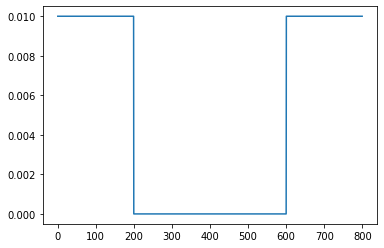

In [50]:
# POTENCIAIS
# scale = 2
V_poco_quadrado_finito = poco_quadrado_finito(
    profundidade=V_0_poco, xmin=xmin_poco, xmax=xmax_poco, x=x
)
def V_hartree(n_3d, k, dx, N, x):
  L=int(dx*(N+1)) 
  V_antes = linalg.solve(laplaciano(dx, N), (-4*pi/k)*n_3d)
  alpha = (V_antes[int((N-3)/4)] - V_antes[int(((3*N)-1)/4)])/(.5*L)
  beta = - V_antes[int((N-3)/4)]
  # x = arange(1, N+1)*dx
  reta_correcao = alpha*(x-(L/4)) + beta
  return V_antes + reta_correcao # V_hartree com as bordas sempre em V=0 !!
  
V_hartree_temperado = lambda tempero, V_1, V_3: f*V_3 + (1-f)*V_1
V_total = lambda V_estrutural, V_interacao: V_estrutural + V_interacao 
plt.plot(x, V_poco_quadrado_finito)
# plt.xlim(399,401)
plt.show()


In [51]:
# E0_mu (soma de níveis ocupados)
E0_mu = lambda mu, E0_list: npsum(E0_list, where=E0_list<=mu)
# Numero de níveis ocupados 
N_levels = lambda mu, E0_list: npsum(E0_list<=mu)
# D.O.L 3D
def n_3d(phi_list, E0_list, mu, m): 
  vectors = array([(m*(mu-E0_list[j])/(2*pi*(h_bar**2)))*(conjugate(phi_list[j])*phi_list[j]) for j in range(N_levels(mu, E0_list))])
  if N_levels(mu, E0_list) > 1:
    return npsum(vectors, axis=0)
  elif N_levels(mu, E0_list) == 1:
    return vectors[0]
  return zeros(N)
# D.O.L 2D
n_2d_params = lambda mu, m, E0_list: [npsum(E0_list<=mu)*m/(2*pi*(h_bar**2)),-E0_mu(mu, E0_list)*m/(2*pi*(h_bar**2))] #retorna os coeficientes linear e angular, n_2d_params[0]==a e n_2d_params[1]==b

In [52]:
# O HAMILTONIANO
H = lambda V_efetivo, m: energia_cinetica(m) + diag(
    V_efetivo
)

In [54]:
# Primeira vez que foi executado o programa:
V_1 = V_h_inicial
V_3 = V_hartree(n_3d_loop, k, dx, N, x)
V_temperado = V_hartree_temperado(0, V_1, V_3)
V_efetivo = V_total(V_poco_quadrado_finito, V_temperado)
V_poco=copy(V_efetivo)
# diagonalização
E0_list, phi_list = linalg.eigh(H(V_efetivo, m))
E0_poco = copy(E0_list)
phi_poco=copy(phi_list)
lista_N_ocupados = []
lista_energias = []
for mu in mu_x:
    N_antes = N_levels(mu, E0_poco)
    print("Niveis ocupados antes do loop =>", N_antes)
    n_3d_loop = n_3d(phi_poco, E0_poco, mu, m)
    n_2d_loop = n_2d_params(mu, m, E0_poco)
    # Loop de autoconsistência:
    convergiu = False
    plotEnPsi_finite_diff(x, append(E0_poco, mu), phi_poco, N_antes, 0.03, -0.0001, V_0_poco, 0, 800, V_poco, "antes-mu="+str(mu))
    cont_ite = []
    n_2d_converg = [copy(n_2d_loop)] #utilizado para pegar os últimos 20 n_2d gerados e testar convergência!
    iteracao = 1
    while not convergiu:
        print("iter=", iteracao)
        cont_ite.append(
            iteracao
        )  #                       Pegando o cont_ite <------- aqui
        V_3 = V_hartree(n_3d_loop, k, dx, N, x)
        V_pro_tempero = copy(V_temperado)
        V_temperado = V_hartree_temperado(f, V_pro_tempero, V_3)
        V_efetivo = V_total(V_poco_quadrado_finito, V_temperado)
        # diagonalização
        E0_list, phi_list = linalg.eigh(H(V_efetivo, m))
        N_ocupados = N_levels(mu, E0_list)
        print("N_ocupados no loop", N_ocupados)
        # TODO>> pensar se esse break eh imprescindível...
        if (N_ocupados > 8):
          print("Saindo do loop.\nExplodiu!")
          break
        enrg_ite_1.append(E0_list[0])  # Pegando o enrg_ite <------- aqui
        enrg_ite_2.append(E0_list[1])  # Pegando o enrg_ite <------- aqui
        n_3d_loop_novo = n_3d(phi_list, E0_list, mu, m)
        n_2d_loop_novo = n_2d_params(mu, m, E0_list)
        n_2d_converg.append(copy(n_2d_loop_novo))
        # teste convergencia STD!!
        if (iteracao >= 20):
            desvio = std(n_2d_converg[-20:], axis=0)
            print("desvio =", desvio)
            iteracao += 1
            if (desvio[0] < epsilon) and (desvio[1] < epsilon):
                n_2dmu.append(n_2d_loop_novo)
                lista_energias.append(E0_mu(mu, E0_list))
                lista_N_ocupados.append(N_levels(mu, E0_list))
                plotEnPsi_finite_diff(x,append(E0_list, mu), phi_list, N_ocupados, 0.03, -0.0001, V_0_poco, 0, 800, V_efetivo, "mu="+str(mu))
                convergiu = True
            else:
                # se nao convergiu
                n_2d_loop = copy(n_2d_loop_novo)
                n_3d_loop = copy(n_3d_loop_novo)
                iteracao += 1
        else:
            # se nao convergiu
            n_2d_loop = copy(n_2d_loop_novo)
            n_3d_loop = copy(n_3d_loop_novo)
            iteracao += 1


Niveis ocupados antes do loop => 1
iter= 1
N_ocupados no loop 1
iter= 2
N_ocupados no loop 1
iter= 3
N_ocupados no loop 1
iter= 4
N_ocupados no loop 1
iter= 5
N_ocupados no loop 1
iter= 6
N_ocupados no loop 1
iter= 7
N_ocupados no loop 1
iter= 8
N_ocupados no loop 1
iter= 9
N_ocupados no loop 1
iter= 10
N_ocupados no loop 1
iter= 11
N_ocupados no loop 1
iter= 12
N_ocupados no loop 1
iter= 13
N_ocupados no loop 1
iter= 14
N_ocupados no loop 1
iter= 15
N_ocupados no loop 1
iter= 16
N_ocupados no loop 1
iter= 17
N_ocupados no loop 1
iter= 18
N_ocupados no loop 1
iter= 19
N_ocupados no loop 1
iter= 20
N_ocupados no loop 1
desvio = [3.46944695e-18 2.15374387e-08]
Niveis ocupados antes do loop => 1
iter= 1
N_ocupados no loop 1
iter= 2
N_ocupados no loop 1
iter= 3
N_ocupados no loop 1
iter= 4
N_ocupados no loop 1
iter= 5
N_ocupados no loop 1
iter= 6
N_ocupados no loop 1
iter= 7
N_ocupados no loop 1
iter= 8
N_ocupados no loop 1
iter= 9
N_ocupados no loop 1
iter= 10
N_ocupados no loop 1
iter= 1

In [56]:
plotEnPsi_finite_diff(x, E0_list, phi_list, N_ocupados, 0.03, -0.0001, 0.015, 0, 800, V_efetivo)

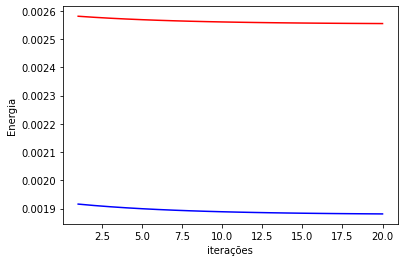

In [57]:
cont_ite = array(cont_ite)
enrg_ite_1 = array(enrg_ite_1)
# print(enrg_ite_1)
enrg_ite_2 = array(enrg_ite_2)

plt.plot(cont_ite, enrg_ite_1[-len(cont_ite):], color='blue')
plt.plot(cont_ite, enrg_ite_2[-len(cont_ite):], color='red')
plt.xlabel("iterações")
plt.ylabel("Energia")
plt.show()

In [58]:
n_2d_y = []
print(len(n_2dmu))
print(len(mu_x))
for i in range(len(mu_x[:len(n_2dmu)])):
    f = n_2dmu[i][0]*mu_x[i] + n_2dmu[i][1]
    n_2d_y.append(f)
n_2d_y = array(n_2d_y)

101
98


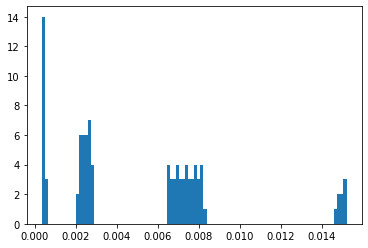

In [85]:
plt.hist(lista_energias,bins=100)
plt.show()

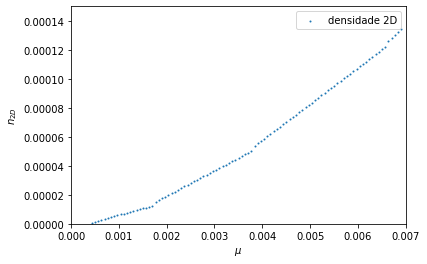

In [98]:
# plt.plot(mu_x[:len(n_2dmu)], n_2d_y, linestyle="dashed", label="densidade 2D")
plt.scatter(mu_x[:len(n_2dmu)], n_2d_y, s=1, label="densidade 2D")
# for E0 in E0_poco[:3]:
#   plt.vlines(E0,0, 0.0001, colors=["black"], label="Energias Poço Sem Interação")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$n_{2D}$')
plt.ylim(0,0.00015)
plt.xlim(0, 0.007)
plt.legend(loc="best")
plt.show()

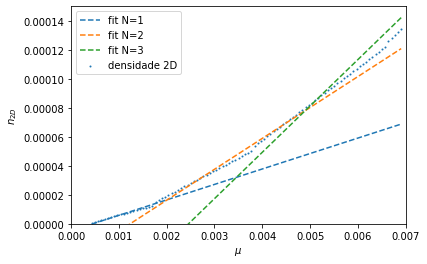

In [97]:
# plt.plot(mu_x[:len(n_2dmu)], n_2d_y, linestyle="dashed", label="densidade 2D")
plt.scatter(mu_x[:len(n_2dmu)], n_2d_y, s=1, label="densidade 2D")
# for E0 in E0_poco[:3]:
#   plt.vlines(E0,0, 0.0001, colors=["black"], label="Energias Poço Sem Interação")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$n_{2D}$')
# Agora, vamos tomar a energia media em cada intervalo de ocupação para tentar fitar a curva n2D vs r'$\mu$' e obter uma reta para cada intervalo.
lista_energias = array(lista_energias)
bp1 = lista_energias[lista_energias < 0.002]
Nbp1 = 1
bp2 = lista_energias[(lista_energias < 0.004) & (lista_energias > 0.002)]
Nbp2 = 2
bp3 = lista_energias[(lista_energias > 0.006) & (lista_energias < 0.01)]
Nbp3 = 3
preFator = m/(2*pi*(h_bar**2))
allBps = [bp1, bp2, bp3]
fit = lambda Nbp, bp: preFator*((Nbp*mu_x) - mean(bp))
for N in range(N_ocupados-1):
  plt.plot(mu_x, fit(N+1, allBps[N]), label="fit N="+str(N+1), linestyle="dashed")
plt.ylim(0,0.00015)
plt.xlim(0, 0.007)
plt.legend(loc="best")
plt.show()

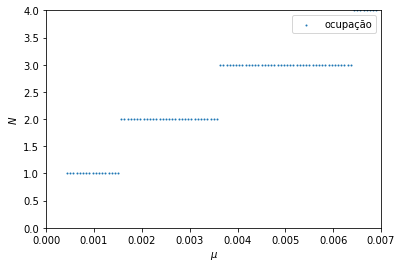

In [81]:
plt.scatter(mu_x[:len(n_2dmu)], lista_N_ocupados,s=1, label="ocupação")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$N$')
plt.legend(loc="best")
plt.xlim(0, 0.007)
plt.ylim(0,4)
plt.show()

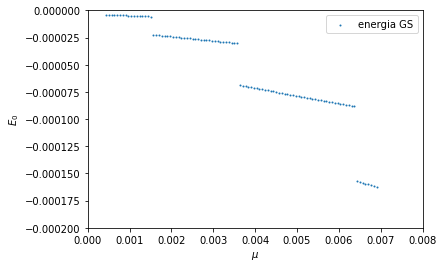

In [73]:
plt.scatter(mu_x[:len(n_2dmu)], -(m/(2*pi*(h_bar**2)))*lista_energias, s=1, label="energia GS")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$E_{0}$')
plt.legend(loc="best")
plt.ylim(-0.0002, 0)
plt.xlim(0, 0.008)
plt.show()